# Sentiment Analysis in Python
In this notebook we will be doing sentiment analysis in python using VADER technique:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach


# Step 1. Read in Data and NLTK Basics

In [80]:
#install scikit-learn in your Python environment using pip
!pip install scikit-learn


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import nltk

In [81]:
# LOAD THE DATA

In [82]:
# Read in data
#The on_bad_lines='skip' parameter tells pandas to skip lines that cause parsing errors, effectively replacing the functionality of the deprecated error_bad_lines parameter.
#Other options for on_bad_lines include 'error' (raise an error) and 'warn' (issue a warning). Choose the option that best suits your data and error handling preferences.
#By setting quoting=3 within pd.read_csv, we tell pandas to ignore quotes within the CSV file
file=r'/content/sample_data/Reviews.csv'
df = pd.read_csv(file, quoting=3, on_bad_lines='skip')
print(df.shape)
df = df.head(500)
print(df.shape)

(363627, 10)
(500, 10)


<ipython-input-82-f4e4e2c19d5b>:6: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, quoting=3, on_bad_lines='skip')


In [83]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [84]:
# Keep only necessary columns.Rest of the columns are not necessary for analyzing the sentiment of the text.
df = df[['Id','Text', 'Score']]

In [25]:
Score=df['Score'].unique()
print(Score)

[5 1 2 4 3]


In [85]:
# Map the ratings to sentiments (assuming 1-2 stars = negative, 3 = neutral, 4-5 = positive)
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'



In [86]:
#create a new column 'sentiment' in your DataFrame df based on the 'Score' column using a function map_rating_to_sentiment
df['sentiment'] = df['Score'].apply(map_rating_to_sentiment)


In [87]:
df

,Id,Text,Score,sentiment
0,1,I have bought several of the Vitality canned d...,5,positive
1,2,"""Product arrived labeled as Jumbo Salted Peanu...",1,negative
2,4,If you are looking for the secret ingredient i...,2,negative
3,9,Right now I'm mostly just sprouting this so my...,5,positive
4,10,This is a very healthy dog food. Good for thei...,5,positive
...,...,...,...,...
495,1751,I love popchips and especially when they are i...,5,positive
496,1762,I love these chips...and my husband does too. ...,5,positive
497,1764,Pop Chips are the best chips I've had in a lon...,5,positive
498,1767,"""I love these chips. They are excellent! On th...",5,positive


In [88]:
# Split the dataset into training and test sets,
"""Splitting: Using stratify=df['sentiment'], the train and test sets will
also have approximately 70% positive, 20% negative, and 10% neutral reviews each.
"""
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [89]:
train_data.shape,test_data.shape

((400, 4), (100, 4))

## step 2 : EDA(Exploratory Data Analysis)

In [90]:
## Check for missing values
df.isnull().sum()

Id           0
Text         0
Score        0
sentiment    0
dtype: int64

In [91]:

df['Score'].value_counts().sort_index()

Score
1     42
2     15
3     30
4     63
5    350
Name: count, dtype: int64

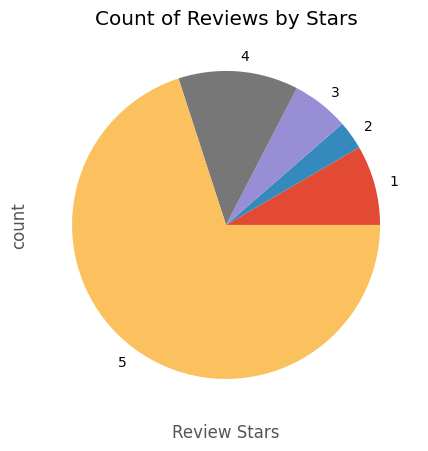

In [19]:
'''
create a pie plot using matplotlib in Python to visualize the count of reviews by star ratings from a DataFrame df.
'''
ax = df['Score'].value_counts().sort_index() \
          .plot(kind='pie',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

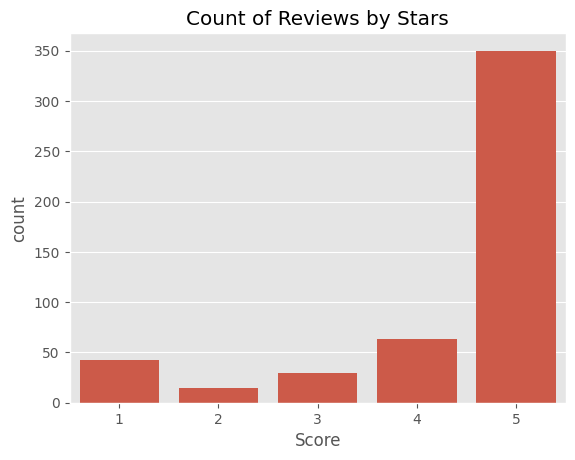

In [15]:
sns.countplot(x='Score',data=df)
plt.title('Count of Reviews by Stars')
plt.show()

## Step 3  NLTK(Preprocessing)

In [92]:
example = df['Text'][7]
print(example)

I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them.


In [93]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [94]:
#tokenizes the example text into a list of words (tokens).
tokens = nltk.word_tokenize(example)
#prints the first 30 tokens from the tokens list.
tokens

['I',
 'love',
 'eating',
 'them',
 'and',
 'they',
 'are',
 'good',
 'for',
 'watching',
 'TV',
 'and',
 'looking',
 'at',
 'movies',
 '!',
 'It',
 'is',
 'not',
 'too',
 'sweet',
 '.',
 'I',
 'like',
 'to',
 'transfer',
 'them',
 'to',
 'a',
 'zip',
 'lock',
 'baggie',
 'so',
 'they',
 'stay',
 'fresh',
 'so',
 'I',
 'can',
 'take',
 'my',
 'time',
 'eating',
 'them',
 '.']

In [95]:
#used for part-of-speech (POS) tagging in NLTK.
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [96]:
#tags each token in the tokens list with its part of speech (e.g., noun, verb, adjective, etc.).
tagged = nltk.pos_tag(tokens)
#tagged[:30]
tagged

[('I', 'PRP'),
 ('love', 'VBP'),
 ('eating', 'VBG'),
 ('them', 'PRP'),
 ('and', 'CC'),
 ('they', 'PRP'),
 ('are', 'VBP'),
 ('good', 'JJ'),
 ('for', 'IN'),
 ('watching', 'VBG'),
 ('TV', 'NN'),
 ('and', 'CC'),
 ('looking', 'VBG'),
 ('at', 'IN'),
 ('movies', 'NNS'),
 ('!', '.'),
 ('It', 'PRP'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('too', 'RB'),
 ('sweet', 'JJ'),
 ('.', '.'),
 ('I', 'PRP'),
 ('like', 'VBP'),
 ('to', 'TO'),
 ('transfer', 'VB'),
 ('them', 'PRP'),
 ('to', 'TO'),
 ('a', 'DT'),
 ('zip', 'NN'),
 ('lock', 'NN'),
 ('baggie', 'NN'),
 ('so', 'IN'),
 ('they', 'PRP'),
 ('stay', 'VBP'),
 ('fresh', 'JJ'),
 ('so', 'IN'),
 ('I', 'PRP'),
 ('can', 'MD'),
 ('take', 'VB'),
 ('my', 'PRP$'),
 ('time', 'NN'),
 ('eating', 'VBG'),
 ('them', 'PRP'),
 ('.', '.')]

In [2]:
#nltk.download('maxent_ne_chunker')

In [3]:
#entities = nltk.chunk.ne_chunk(tagged)
#entities.pprint()

In [97]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [36]:
#Apply Preprocessing to the Dataset

In [98]:
df['Text']=df['Text'].apply(preprocess_text)

In [99]:
train_data['cleaned_Text'] = train_data['Text'].apply(preprocess_text)
test_data['cleaned_Text'] = test_data['Text'].apply(preprocess_text)

In [100]:
train_data[['Text','cleaned_Text']].iloc[0]

Text            These potatoes are really very good.  My husba...
cleaned_Text      potato really good husband love way easy buying
Name: 0, dtype: object

In [45]:
# Wordcloud for postive and negative scores(visualize the text data and Identify the most frequent terms quickly)

In [101]:
positive_texts = df['Text'][df['sentiment'] == 'positive']
positive_texts

0      bought several vitality canned dog food produc...
3      right im mostly sprouting cat eat grass love r...
4      healthy dog food good digestion also good smal...
5      good flavor came securely packed fresh delicio...
6      strawberry twizzlers guilty pleasure yummy six...
                             ...                        
495    love popchips especially individual portion si...
496    love chipsand husband wipe get variety pack gr...
497    pop chip best chip ive long time im weight wat...
498    love chip excellent weight watcher plan point ...
499    variety pack popchips r sooo good flavor r del...
Name: Text, Length: 413, dtype: object

In [102]:
positive_text=' '.join(positive_texts)
positive_text

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better right im mostly sprouting cat eat grass love rotate around wheatgrass rye healthy dog food good digestion also good small puppy dog eats required amount every feeding good flavor came securely packed fresh delicious love twizzlers strawberry twizzlers guilty pleasure yummy six pound around son satisfied twizzler purchase shared others enjoyed definitely ordering candy delivered fast purchased reasonable price home bound unable get store perfect remember buying candy kid quality hasnt dropped year still superb product wont disappointed love candy weight watcher cut back still craving glad amazon carried battery hard time finding elsewhere unique size need garage door openerbr great deal price mccanns oatmeal every morning ordering amazon able save almost per boxbr great product taste great healthy really like mccanns steel cut

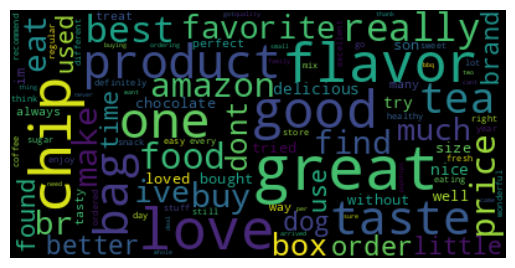

In [103]:
from wordcloud import WordCloud
wordcloud=WordCloud(max_font_size=50,max_words=100,background_color="black").generate(positive_text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [104]:
negative_texts=df['Text'][df['sentiment']=='negative']
negative_text=' '.join(negative_texts)

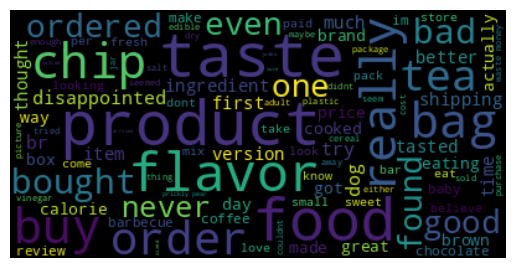

In [105]:
wordcloud=WordCloud(max_font_size=50,max_words=100,background_color="black").generate(negative_text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# Step 4. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [106]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [107]:
#SentimentIntensityAnalyzer is specifically designed to analyze the sentiment of text, particularly for social media content.
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #tqdm  tracking the progress of long-running operations

sia = SentimentIntensityAnalyzer()

In [108]:
# will analyze the given text and return a dictionary of sentiment scores.
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [109]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [110]:
example

'I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them.'

In [111]:
sia.polarity_scores(example)

{'neg': 0.097, 'neu': 0.694, 'pos': 0.209, 'compound': 0.7481}

In [112]:
# Run the polarity score on the entire dataset.
'''Use tqdm to iterate through the DataFrame rows and
calculate VADER sentiment scores for each preprocessed text'''
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [113]:
pd.DataFrame(res).T

,neg,neu,pos,compound
1,0.000,0.503,0.497,0.9413
2,0.129,0.762,0.110,-0.1027
4,0.000,0.854,0.146,0.4404
9,0.000,0.724,0.276,0.6369
10,0.000,0.585,0.415,0.8176
...,...,...,...,...
1751,0.000,0.517,0.483,0.9042
1762,0.000,0.519,0.481,0.9552
1764,0.118,0.640,0.242,0.5719
1767,0.000,0.525,0.475,0.9803


In [114]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [115]:
# Now we have sentiment score and metadata
vaders.tail(20)

,Id,neg,neu,pos,compound,Text,Score,sentiment
480,1716,0.000,0.707,0.293,0.4404,everyone try chip healthier regular chip taste...,5,positive
481,1719,0.000,0.554,0.446,0.9169,possibly best salt vinegar chip healthy ever s...,4,positive
482,1722,0.068,0.456,0.476,0.9100,popchips nice alternative potato chip greasy c...,5,positive
483,1723,0.000,0.614,0.386,0.9061,totally amazing deliciousbr br favorite flavor...,5,positive
484,1724,0.000,0.696,0.304,0.7620,salt vinegar bbq rock plain okdidnt really car...,5,positive
485,1729,0.106,0.707,0.187,0.3818,excellent taste low calorie snack size bag exa...,5,positive
486,1730,0.000,0.794,0.206,0.8442,expectedidkmaybe tasteless cardboardbut really...,5,positive
487,1732,0.000,0.452,0.548,0.8655,love popchips really treat get variety flavor ...,5,positive
488,1738,0.000,0.374,0.626,0.9136,great product flavor delicious loved fact sing...,5,positive
489,1740,0.066,0.677,0.257,0.6839,impressed flavor flavor wasnt sure going likeb...,5,positive


## Plot VADER results

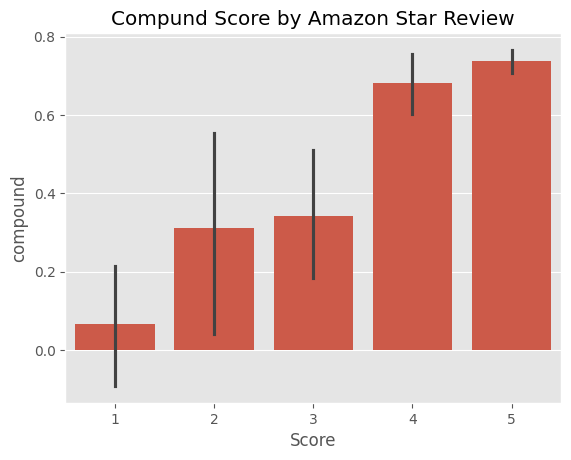

In [116]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

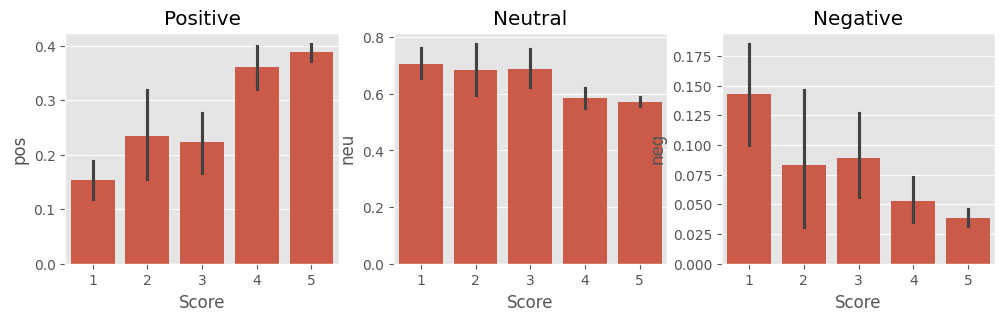

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
#plt.tight_layout()
plt.show()

In [118]:
def vader_sentiment_analysis(text):
    vs = sia.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'positive'
    elif vs['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [119]:
train_data['predicted_sentiment'] = train_data['cleaned_Text'].apply(vader_sentiment_analysis)

In [62]:
train_data

,Id,Text,Score,sentiment,cleaned_Text,predicted_sentiment
0,1221,These potatoes are really very good. My husba...,5,positive,potato really good husband love way easy buying,positive
1,413,This is the best way to cook a roast. Our loc...,5,positive,best way cook roast local grocery went buisnes...,positive
2,768,Of all the coffee's available for Tassimo this...,5,positive,coffee available tassimo kona richest flavor f...,positive
3,1291,Our four dogs love this stuff! This bite size ...,5,positive,four dog love stuff bite size treat perfect si...,positive
4,1134,my cats favorite cat food he is very pickey an...,5,positive,cat favorite cat food pickey eat lot different...,positive
...,...,...,...,...,...,...
395,734,This cinnamon cake loaf has a wonderful natura...,5,positive,cinnamon cake loaf wonderful natural flavor mo...,positive
396,1084,All my fault. I thought this would be a carton...,1,negative,fault thought would carton box cereal instead ...,negative
397,1154,Very disappointed with purchase. The dates we...,1,negative,disappointed purchase date dried tasted like l...,negative
398,1431,My husband and I fell in love with Cafe Britt ...,5,positive,husband fell love cafe britt coffee costa rica...,positive


In [120]:
# Evaluate the results
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(train_data['sentiment'], train_data['predicted_sentiment'])
report = classification_report(train_data['sentiment'], train_data['predicted_sentiment'])

print(f"VADER Train Accuracy: {accuracy}")
print(f"VADER Classification Report:\n{report}")

VADER Train Accuracy: 0.815
VADER Classification Report:
              precision    recall  f1-score   support

    negative       0.43      0.28      0.34        46
     neutral       0.18      0.12      0.15        24
    positive       0.88      0.94      0.91       330

    accuracy                           0.81       400
   macro avg       0.50      0.45      0.47       400
weighted avg       0.78      0.81      0.80       400



In [121]:
# Apply VADER to the cleaned test set
test_data['predicted_sentiment'] = test_data['cleaned_Text'].apply(vader_sentiment_analysis)

In [122]:
test_data

,Id,Text,Score,sentiment,cleaned_Text,predicted_sentiment
0,106,I like Creme Brulee. I loved that these were s...,5,positive,like creme brulee loved easy sprinkle sugar ca...,positive
1,1006,I purchased these little treats as stocking st...,5,positive,purchased little treat stocking stuffer little...,positive
2,194,These little guys are tasty and refreshing.<br...,5,positive,little guy tasty refreshingbr br usually eat s...,positive
3,1236,Where's the ingredient list for this product? ...,1,negative,wheres ingredient list product thought food su...,neutral
4,619,I dont know if they were fresh or if they were...,3,neutral,dont know fresh supposed taste like checked ex...,positive
...,...,...,...,...,...,...
95,977,I live in the dorms without a kitchen so makin...,4,positive,live dorm without kitchen making cup coffee re...,positive
96,454,My husband and I LOVE these chips! Personally ...,5,positive,husband love chip personally think flavor perf...,positive
97,1095,Mine came with stickers to sell them for $1.59...,5,positive,mine came sticker sell cost like retail much m...,positive
98,133,I really loved the spicy flavor these had. I ...,5,positive,really loved spicy flavor found liking broth n...,positive


In [123]:
# Evaluate the results
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_data['sentiment'], test_data['predicted_sentiment'])
report = classification_report(test_data['sentiment'], test_data['predicted_sentiment'])

print(f"VADER Accuracy: {accuracy}")
print(f"VADER Classification Report:\n{report}")

VADER Accuracy: 0.85
VADER Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.45      0.50        11
     neutral       0.25      0.17      0.20         6
    positive       0.91      0.95      0.93        83

    accuracy                           0.85       100
   macro avg       0.57      0.52      0.54       100
weighted avg       0.83      0.85      0.84       100



In [70]:
#Save the SentimentIntensityAnalyzer Object to a Pickle File

In [124]:
import pickle
import joblib # Import the joblib library
# Save the SentimentIntensityAnalyzer object to a pickle file
with open('vader_sentiment_analyzer.pkl', 'wb') as file:
    pickle.dump(sia, file)



In [125]:
with open('vader_sentiment_analyzer.pkl', 'rb') as file:
  model=joblib.load(file)

In [126]:
# Load the SentimentIntensityAnalyzer object from the pickle file
#with open('vader_sentiment_analyzer.pkl', 'rb') as file:
    #sia_loaded = pickle.load(file)

# Example text
text = "I am so happy!"

# Get the sentiment scores using the loaded model
scores = model.polarity_scores(text)

# Display the scores
print(scores)

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}


# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [127]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [128]:
#Load the pre-trained model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [129]:
# VADER results on example
print(example)
sia.polarity_scores(example)

I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them.


{'neg': 0.097, 'neu': 0.694, 'pos': 0.209, 'compound': 0.7481}

In [130]:
encoded_text = tokenizer(example, return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0,   100,   657,  4441,   106,     8,    51,    32,   205,    13,
          2494,  1012,     8,   546,    23,  4133,   328,    85,    16,    45,
           350,  4045,     4,    38,   101,     7,  2937,   106,     7,    10,
         23595,  7014,  3298, 25004,    98,    51,  1095,  2310,    98,    38,
            64,   185,   127,    86,  4441,   106,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [131]:
output = model(**encoded_text)
output
output[0][0].detach().numpy()

array([-2.1688056 , -0.64456457,  3.650003  ], dtype=float32)

In [132]:
scores = output[0][0].detach().numpy()
scores
scores = softmax(scores)
scores

array([0.00292259, 0.01341952, 0.9836579 ], dtype=float32)

In [77]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.002922588, 'roberta_neu': 0.013419523, 'roberta_pos': 0.9836579}


In [133]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [134]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        #**************************************************
        # Determine RoBERTa sentiment label
        #roberta_label = max(roberta_result, key=roberta_result.get).split('_')[1]
        # Determine RoBERTa sentiment label and map to full words
        roberta_label = max(roberta_result, key=roberta_result.get)
        label_map = {
            'roberta_neg': 'negative',
            'roberta_neu': 'neutral',
            'roberta_pos': 'positive'
        }
        roberta_full_label = label_map[roberta_label]

        #**************************************************
        both = {**vader_result_rename, **roberta_result,'roberta_sentiment': roberta_full_label}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [83]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [84]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,roberta_sentiment,Text,Score,sentiment
0,1,0.0,0.503,0.497,0.9413,0.009324,0.102123,0.888553,positive,bought several vitality canned dog food produc...,5,positive
1,2,0.129,0.762,0.11,-0.1027,0.087291,0.848,0.06471,neutral,product arrived labeled jumbo salted peanutsth...,1,negative
2,4,0.0,0.854,0.146,0.4404,0.005513,0.342441,0.652047,positive,looking secret ingredient robitussin believe f...,2,negative
3,9,0.0,0.724,0.276,0.6369,0.014226,0.647114,0.338661,neutral,right im mostly sprouting cat eat grass love r...,5,positive
4,10,0.0,0.585,0.415,0.8176,0.00697,0.197464,0.795567,positive,healthy dog food good digestion also good smal...,5,positive


In [85]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(results_df['sentiment'], results_df['roberta_sentiment'])
report = classification_report(results_df['sentiment'], results_df['roberta_sentiment'])

print(f"Roberta Accuracy: {accuracy}")
print(f"Roberta Classification Report:\n{report}")

Roberta Accuracy: 0.792
Roberta Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.49      0.54        57
     neutral       0.19      0.53      0.28        30
    positive       0.95      0.85      0.90       413

    accuracy                           0.79       500
   macro avg       0.58      0.63      0.57       500
weighted avg       0.87      0.79      0.82       500



## Compare Scores between models

In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'roberta_sentiment',
       'Text', 'Score', 'sentiment'],
      dtype='object')

# Step 3. Combine and compare

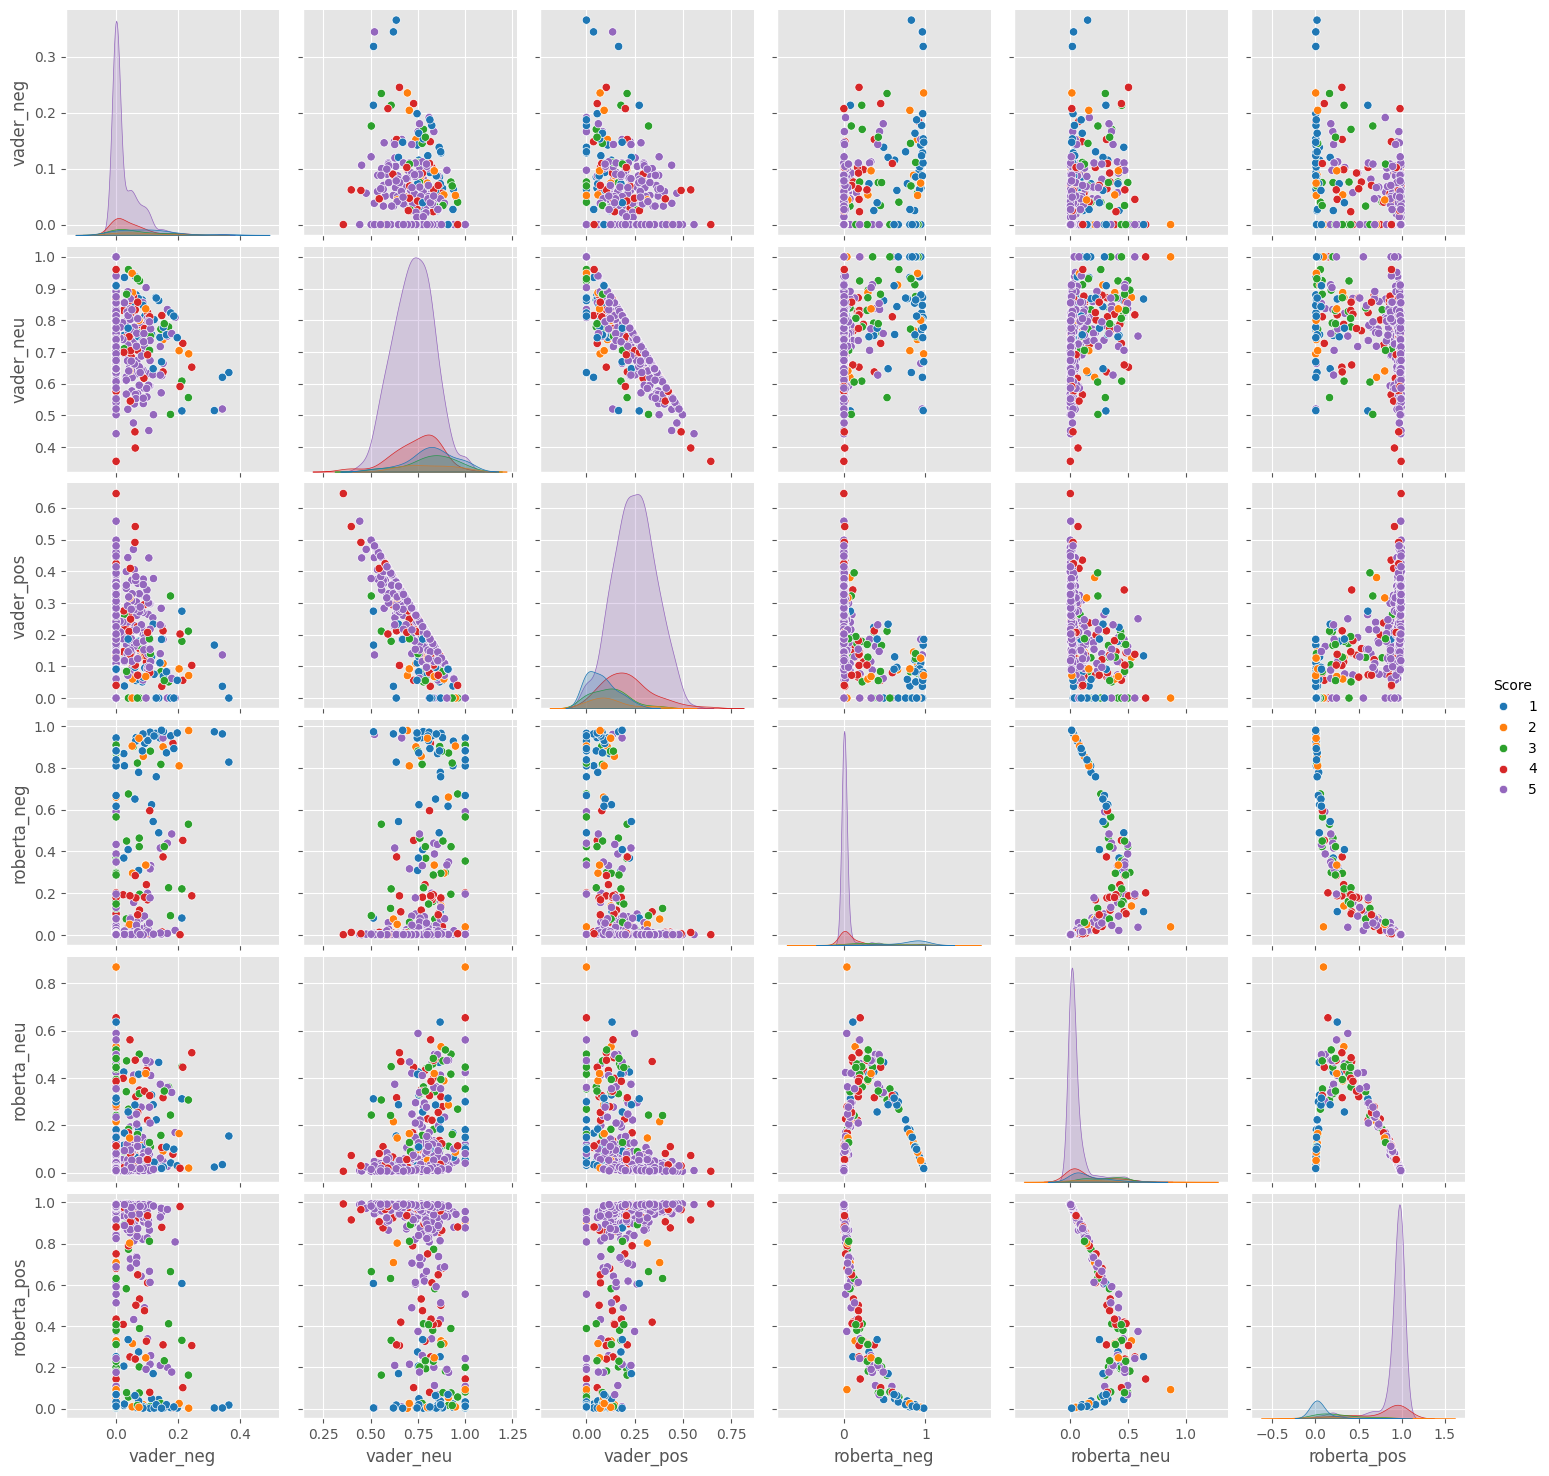

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
# negative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('Product is awesome')

[{'label': 'POSITIVE', 'score': 0.9998762607574463}]

In [ ]:
sent_pipeline('bad')

[{'label': 'NEGATIVE', 'score': 0.999782383441925}]